# Centrality Measures of road network

In [2]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-04T15:48:23.385994+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely
from shapely.geometry import Point
from shapely.ops import nearest_points
from pyproj import Transformer
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%watermark -w
%watermark -iv

Watermark: 2.4.3

pulp      : 2.8.0
geopandas : 0.14.3
osmnx     : 1.9.1
pandana   : 0.7
numpy     : 1.26.4
matplotlib: 3.8.3
shapely   : 2.0.3
pandas    : 2.2.1
networkx  : 3.2.1



## 1. Load the data
### 1.1 Loading a small road network of Grünerløkka for testing.
For all input data we change the CRS from WGS84 to UTM33N. This is done to make the distance calculations easier.  
Also trying to use pygeos instead of shapely for faster geometry operations. However, pygeos is not entirely integrated with geopandas yet, so we need to convert geometries back to shapely geometries for inserting them into geopandas dataframes.

In [4]:
### Road network file of Grünerløkka, Oslo

# 1) Read from local path
# gruner_filepath = "C:/Users/torha/prog.div/PiT/osmnx-oslo/data/grünerlokka_road_network.gpkg"    # GeoPackage format
gruner_filepath = "../data/oslo_city/GrunerServiceImputed.graphml" # GraphML format (with speed and travel time)
gruner_graph = ox.load_graphml(gruner_filepath) # originally in WGS84 (EPSG:4326)

# 2) Fetch from OSM - using OSMnx 
# gruner_graph = ox.graph_from_place('Grünerløkka, Oslo, Norway', network_type="drive_service") # originally in WGS84 (EPSG:4326)

In [5]:
gruner_graph = ox.projection.project_graph(gruner_graph, to_crs='EPSG:32633') # project to UTM zone 33N
print(f"Type of gruner_graph: {type(gruner_graph)}")
print(f"CRS of gruner_graph:  {gruner_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(gruner_graph, node_size=4, edge_linewidth=0.5, edge_color="w")

Type of gruner_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of gruner_graph:  EPSG:32633


Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [19]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(gruner_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
# edges.head(3) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


## 2. Define the origin and destination points

In [20]:
# set seed for reproducibility
seed = 42
nr_of_car_nodes = 25
nodes_sample = nodes.sample(1010, random_state=seed) # sample 1010 random source nodes
car_nodes = nodes_sample.iloc[:nr_of_car_nodes] # first 10 nodes are cars
event_nodes = nodes_sample.iloc[nr_of_car_nodes:]   # rest of nodes are events
print(f"Total nr of nodes: {len(nodes)}, nr of facility nodes: {len(car_nodes)}, nr of client nodes: {len(event_nodes)}")
nodes_sample.head(3)

Total nr of nodes: 1147, nr of facility nodes: 25, nr of client nodes: 985


,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
1200788653,6650962.609,263720.996,1,10.771,59.928,NaN,NaN,POINT (263720.996 6650962.609)
10026959862,6650672.488,263912.191,1,10.775,59.926,NaN,NaN,POINT (263912.191 6650672.488)
11398964194,6650802.368,265277.701,1,10.799,59.928,NaN,NaN,POINT (265277.701 6650802.368)


## 3. Centrality measures
We have sampled random points from the road network. Next we filter the candidate points on the following critera to discard the most unsuitable points.  
This will reduce computational time and make the LP problem more manageable.

- Distance from each other
- Centrality of the point in the road network

### 3.1 NetworkX node centrality
NetworkX is easy to use and has a lot of centrality measures.   
However, it is not the fastest library for large graphs.



In [21]:
%time
# Compute all of NetworkX centrality measures for nodes
# node closeness centrality
node_centrality = nx.closeness_centrality(gruner_graph, wf_improved=True, distance="travel_time")

# node betweenness centrality
node_betweenness = nx.betweenness_centrality(gruner_graph, normalized=True, weight="travel_time")

# node degree centrality
node_degree = nx.degree_centrality(gruner_graph)

# node eigenvector_centrality (not implemented for multigraphs)

# node eigenvector centrality numpy
node_eigenvector = nx.eigenvector_centrality_numpy(gruner_graph, weight="travel_time")

# node load centrality
node_load = nx.load_centrality(gruner_graph, normalized=True, weight="travel_time")

# node pagerank centrality
node_pagerank = nx.pagerank(gruner_graph, weight="travel_time")

# print first 5 nodes with highest closeness centrality
print("Node centrality type:", type(node_centrality))
print("Node : Closeness Centrality")
for key, value in sorted(node_centrality.items(), key=lambda item: item[1], reverse=True)[:5]:
    print(f"{key}: {value:.4f}")

CPU times: total: 0 ns
Wall time: 0 ns


Node centrality type: <class 'dict'>
Node : Closeness Centrality
2481252174: 0.0091
841832179: 0.0091
841832141: 0.0091
79499: 0.0090
1199008315: 0.0090


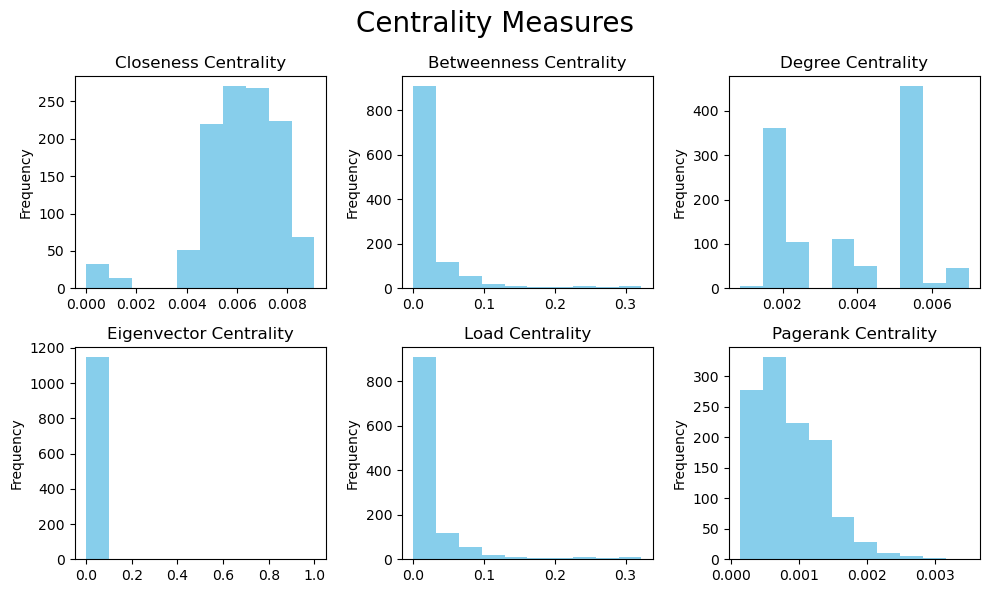

In [34]:
# Use matplotlib and subplots to visualize the centrality measures
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle("Centrality Measures", fontsize=20)

# plot node closeness centrality
nc = pd.Series(node_centrality)
nc.plot(ax=axes[0, 0], kind="hist", title="Closeness Centrality", color="skyblue")

# plot node betweenness centrality
nb = pd.Series(node_betweenness)
nb.plot(ax=axes[0, 1], kind="hist", title="Betweenness Centrality", color="skyblue")

# plot node degree centrality
nd = pd.Series(node_degree)
nd.plot(ax=axes[0, 2], kind="hist", title="Degree Centrality", color="skyblue")

# plot node eigenvector centrality
ne = pd.Series(node_eigenvector)
ne.plot(ax=axes[1, 0], kind="hist", title="Eigenvector Centrality", color="skyblue")

# plot node load centrality
nl = pd.Series(node_load)
nl.plot(ax=axes[1, 1], kind="hist", title="Load Centrality", color="skyblue")

# plot node pagerank centrality
np = pd.Series(node_pagerank)
np.plot(ax=axes[1, 2], kind="hist", title="Pagerank Centrality", color="skyblue")
plt.tight_layout(); plt.show()

C:\Users\torha\AppData\Local\Temp\ipykernel_10196\4196120090.py:3: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)


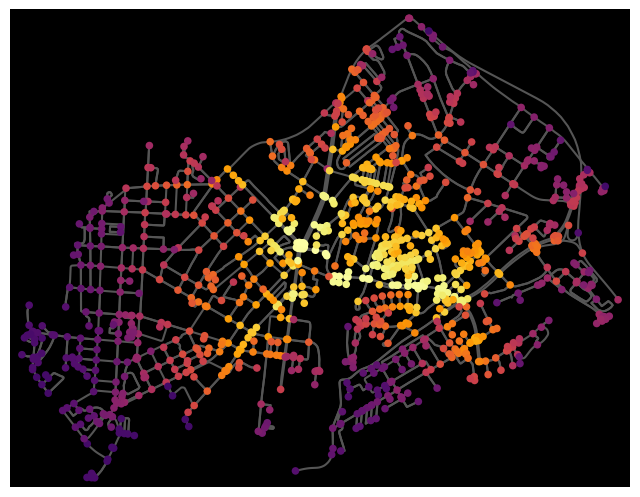

C:\Users\torha\AppData\Local\Temp\ipykernel_10196\4196120090.py:11: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)


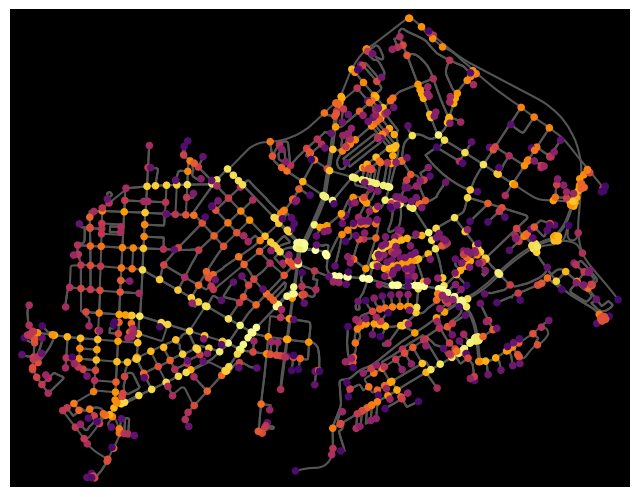

C:\Users\torha\AppData\Local\Temp\ipykernel_10196\4196120090.py:19: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)


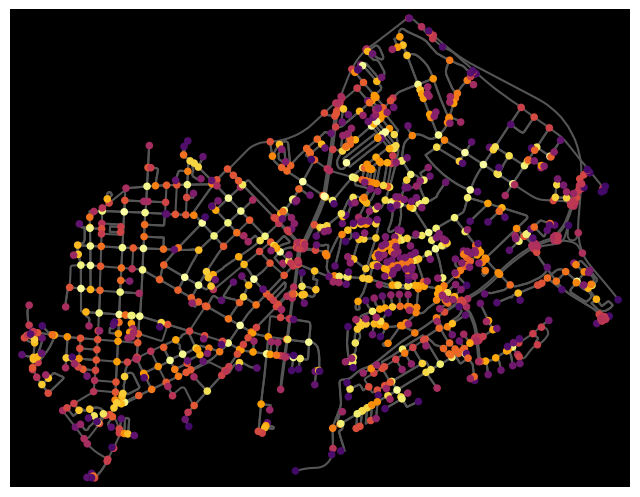

C:\Users\torha\AppData\Local\Temp\ipykernel_10196\4196120090.py:27: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)


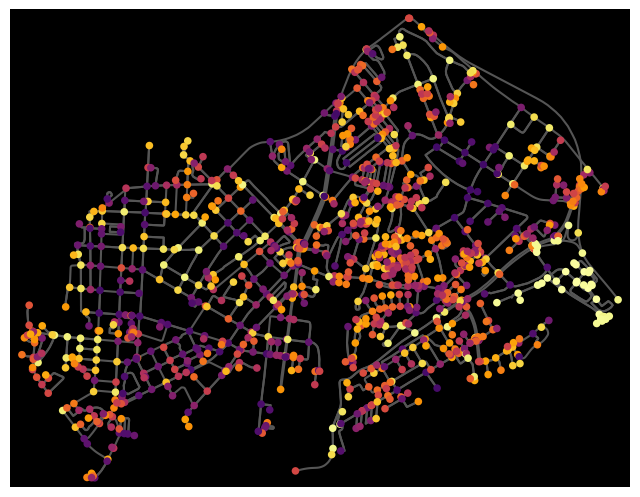

C:\Users\torha\AppData\Local\Temp\ipykernel_10196\4196120090.py:35: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)


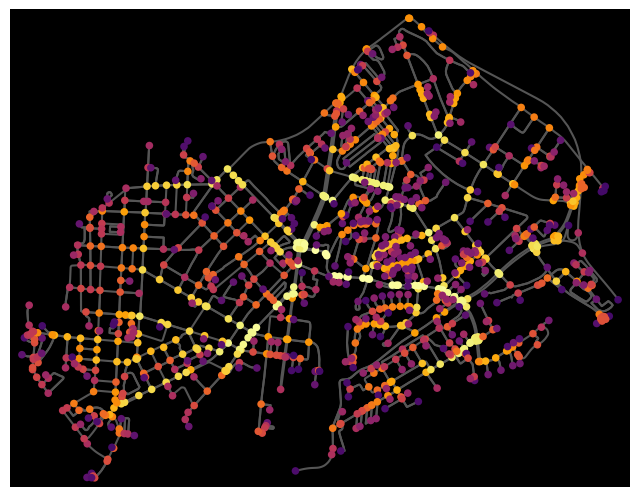

C:\Users\torha\AppData\Local\Temp\ipykernel_10196\4196120090.py:43: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)


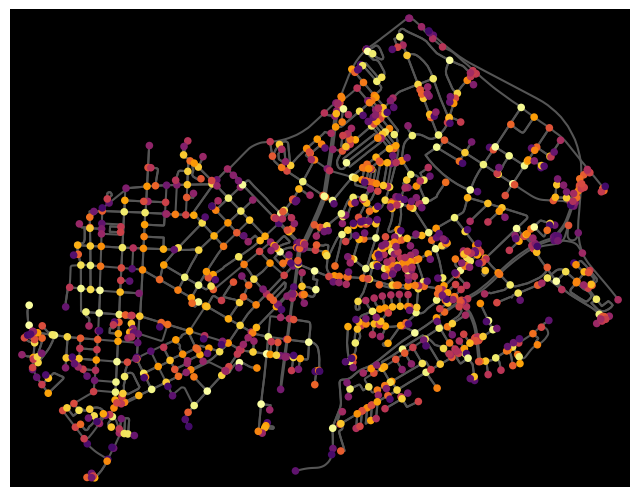

In [23]:
# plot the graph with the node centrality as node color
df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(gruner_graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(gruner_graph, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

# plot the graph with betweenness centrality as node color
df = pd.DataFrame(data=pd.Series(node_betweenness).sort_values(), columns=['bc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(gruner_graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(gruner_graph, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

# plot the graph with degree centrality as node color
df = pd.DataFrame(data=pd.Series(node_degree).sort_values(), columns=['dc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(gruner_graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(gruner_graph, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

# plot the graph with eigenvector centrality as node color
df = pd.DataFrame(data=pd.Series(node_eigenvector).sort_values(), columns=['ec'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(gruner_graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(gruner_graph, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

# plot the graph with load centrality as node color
df = pd.DataFrame(data=pd.Series(node_load).sort_values(), columns=['lc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(gruner_graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(gruner_graph, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

# plot the graph with pagerank centrality as node color
df = pd.DataFrame(data=pd.Series(node_pagerank).sort_values(), columns=['prc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(gruner_graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(gruner_graph, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

In [40]:
# closeness centrality was most useful, so we should add it as a column to the nodes GeoDataFrame
nodes['closeness_centrality'] = pd.Series(node_centrality)
nodes.head(3)

,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
79448,6650300.213,262538.332,3,10.751,59.922,NaN,NaN,POINT (262538.332 6650300.213),0.004
3165357950,6650406.186,262538.592,3,10.751,59.923,NaN,NaN,POINT (262538.592 6650406.186),0.004
79465,6651034.904,263161.645,4,10.761,59.928,traffic_signals,NaN,POINT (263161.645 6651034.904),0.006


In [38]:
# Select out remote nodes with lowest close centrality
remote_nodes = sorted(node_centrality.items(), key=lambda item: item[1], reverse=False)[:100]
remote_nodes = [x[0] for x in remote_nodes]
remote_nodes = nodes.loc[remote_nodes]
# remote_nodes.head(3)

Discard nodes: most remote nodes with lowest closeness centrality


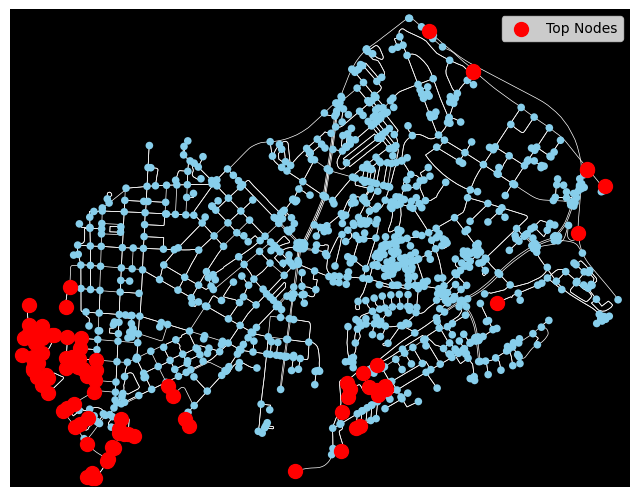

In [39]:
# Plot all nodes and top nodes in different colors
fig, ax = ox.plot_graph(gruner_graph, node_color="skyblue", node_size=30, edge_linewidth=0.5, edge_color="w", bgcolor="k", show=False, close=False)
ax.scatter(remote_nodes["x"], remote_nodes["y"], s=100, c="r", marker="o", label="Top Nodes")
ax.legend()
print("Discard nodes: most remote nodes with lowest closeness centrality")

### 3.2 NetworkX edge centrality

In [26]:
%%time
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(gruner_graph))
nx.set_edge_attributes(gruner_graph, edge_centrality, "edge_centrality")

# color edges in original graph with closeness centralities from line graph
# ec = ox.plot.get_edge_colors_by_attr(gruner_graph, attr="edge_centrality", cmap="inferno")
# fig, ax = ox.plot_graph(gruner_graph, edge_color=ec, edge_linewidth=2, node_size=0, bgcolor="k", show=False, close=False)

CPU times: total: 4.12 s
Wall time: 4.84 s


C:\Users\torha\AppData\Local\Temp\ipykernel_10196\2174267897.py:3: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)


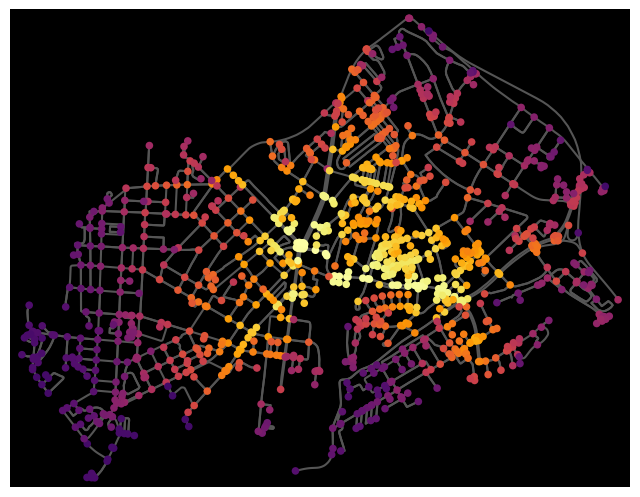

In [27]:
# plot it
df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(gruner_graph.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(gruner_graph, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)